# CartPole v0 Deep Q-Network

CartPole v0 problem resolution using DQN (Q-Learning using Neural Network and experience replay) with Tensorflow.
See [online example](https://gym.openai.com/evaluations/eval_CABwYtsAQ6C9F19XwGz2w) at Gym OpenAI.

In [1]:
import numpy as np
import random
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, 'CartPole-record',force=True)

[2017-08-26 17:31:51,543] Making new env: CartPole-v0
[2017-08-26 17:31:51,562] Clearing 24 monitor files from previous run (because force=True was provided)


## Config

In [12]:
# Env variables
nb_actions = 2

# Training tuning
train_batch_size = 10
e = 0.5
e_decay = 0.99
y = .9
lr = 1.0

# Training loop
nb_max_episodes = 3000
episode_count = 0
total_steps = 0
update_freq = 100
test_freq = 100
log_freq = 100

## Training

### Model

In [4]:
n_input = 4
n_hidden_1 = 128
n_hidden_2 = 128

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, nb_actions]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([nb_actions]))
}

tf.reset_default_graph()

x = tf.placeholder(shape=[None,4],dtype=tf.float32)
layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
Qout = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])

nextQ = tf.placeholder(shape=[None,nb_actions],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
update_model = trainer.minimize(loss)

### Experience Replay

In [6]:
class ExperienceBuffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer = self.buffer[:1]
        self.buffer.append(experience)
            
    def sample(self,size):
        return random.sample(self.buffer, size)

### Test accurracy

In [7]:
def test_accurracy():
    test_batch_size = 100
    c = 0
    nb_success = 0.0
    max_time, min_time = 0.0, float('inf')
    while c < test_batch_size:
        j = 0
        is_gameover = False
        state = env.reset()
        while not is_gameover:
            j += 1
            Q1 = sess.run(Qout, feed_dict={x: [state]})[0]
            action = np.argmax(Q1)
            next_state, reward, is_gameover, _ = env.step(action)
#             env.render()
            state = next_state
        nb_success += j
        max_time = max(j, max_time)
        min_time = min(j, min_time)
        c += 1
    return nb_success / c, min_time, max_time

### Training Loop

In [8]:
mean_times = []
rewards = []
minus_hist = []
plus_hist = []

init = tf.global_variables_initializer()

replay_buffer = ExperienceBuffer()

finished = False

with tf.Session() as sess:
    sess.run(init)
    
    while not finished:
        state = env.reset()
        is_gameover = False
        reward_tot = 0
        episode_step = 0
        
        while not is_gameover:
            episode_step += 1

            # Eval current state
            Q1 = sess.run(Qout, feed_dict={x: [state]})[0]
            
            action_minus, action_plus = Q1
            minus_hist.append(action_minus)
            plus_hist.append(action_plus)
            
            if random.random() < e:
                action = random.randint(0, nb_actions-1)
            else:
                action = np.argmax(Q1)
                
            # Play best move with chance of random
            next_state, reward, is_gameover, _ = env.step(action)
            
            if is_gameover:
                reward = -100
                
            # Eval next state
            Q2 = sess.run(Qout, feed_dict={x: [next_state]})[0]
            
            # Update first state evaluation
            Q1[action] += lr * (reward + y*np.max(Q2) - Q1[action])
            sess.run(update_model,feed_dict={x: [state], nextQ:[Q1]})

            # Register experience
            replay_buffer.add((state,Q1))

            reward_tot += reward
            total_steps += 1
            state = next_state

            if is_gameover:
                break

            e *= e_decay
        
        if total_steps % (update_freq) == 0 and len(replay_buffer.buffer) > train_batch_size:
            train_batch = replay_buffer.sample(train_batch_size)
            train_x, train_Q = list(zip(*train_batch))
            
            #Update the network with our target values.
            sess.run(update_model, feed_dict={
                x: train_x,
                nextQ: train_Q
            })
        
        if episode_count % test_freq == 0 and episode_count != 0:
            mean_time, min_time, max_time = test_accurracy()
            mean_times.append(mean_time)

            if episode_count % log_freq == 0:
                print('step: %s, episode: %s, mean time: %s. min: %s. max: %s. random move probability: %s' 
                      % (total_steps, episode_count, mean_time, min_time, max_time, e))
                
            if mean_time > 196:
                finished = True
                
        episode_count += 1
        rewards.append(reward_tot)
    env.close()

[2017-08-26 17:32:01,306] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000000.mp4
[2017-08-26 17:32:02,263] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000001.mp4
[2017-08-26 17:32:03,709] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000008.mp4
[2017-08-26 17:32:06,172] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000027.mp4
[2017-08-26 17:32:09,057] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000064.mp4
[2017-08-26 17:32:11,735] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.vide

step: 5196, episode: 100, mean time: 53.69. min: 22. max: 81. random move probability: 2.88593455884936e-23


[2017-08-26 17:32:14,651] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000216.mp4
[2017-08-26 17:32:26,861] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000343.mp4


step: 16413, episode: 200, mean time: 188.67. min: 125. max: 200. random move probability: 8.644598353212519e-72


[2017-08-26 17:32:49,647] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000512.mp4


step: 34317, episode: 300, mean time: 184.7. min: 124. max: 200. random move probability: 1.6817035253530329e-149


[2017-08-26 17:33:13,544] Starting new video recorder writing to D:\workspace\rl-dojo\gym_cartpole_v0\qlearning_nn\CartPole-record\openaigym.video.0.41032.video000729.mp4
[2017-08-26 17:33:20,589] Finished writing results. You can upload them to the scoreboard via gym.upload('D:\\workspace\\rl-dojo\\gym_cartpole_v0\\qlearning_nn\\CartPole-record')


step: 50321, episode: 400, mean time: 196.44. min: 130. max: 200. random move probability: 6.425165430218056e-219


### Metrics

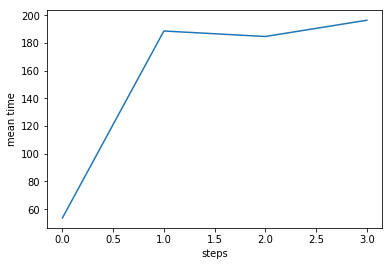

In [10]:
import matplotlib.pyplot as plt
plt.plot(mean_times)
plt.xlabel('steps')
plt.ylabel('mean time')
plt.show()

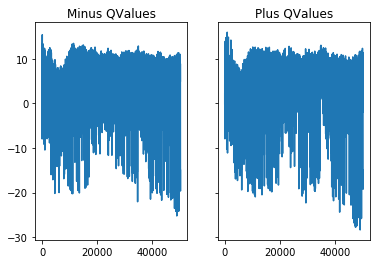

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(minus_hist)
ax1.set_title('Minus QValues')
ax2.plot(plus_hist)
ax2.set_title('Plus QValues')
plt.show()

### Upload results on Gym OpenAI

In [9]:
gym.upload('CartPole-record', api_key='your_key')

[2017-08-26 17:33:59,265] [CartPole-v0] Uploading 801 episodes of training data
[2017-08-26 17:34:02,189] [CartPole-v0] Uploading videos of 10 training episodes (75956 bytes)
[2017-08-26 17:34:02,793] [CartPole-v0] Creating evaluation object from CartPole-record with learning curve and training video
[2017-08-26 17:34:03,145] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_yii4hTCcRky6P5E2MIWihw

****************************************************
